In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

from include.Connection import Connection
from include.Tools import *
import pandas as pd
import numpy as np
import datetime as dt

In [2]:
# filePath = './connection.test.log'
logDate = "2020-05-13"
filePath = "./logs/connection.{0}.log".format(logDate)
df = pd.DataFrame()
start_time = dt.datetime.now()

with open(file = filePath, mode = "r", buffering = 1_000_000) as f:
    for line in f:
        keys, values = Connection.parse(line)
        df = df.append(pd.DataFrame(data=[values], columns=keys), ignore_index=True)

# --- Set DataFrame.index to the unique "ID" field:
df.set_index("ID", inplace=True)
# --- Replace noname user name with "NaN" value:
df["User"].mask(df["User"] == "", "NaN", inplace=True)

# --- Replace empty DestinationHostName with their DestinationIp.
# in some cases it looks like Kerio bug, 
# where, for a bunch of lines with the same Destination IP
# there is just missing Destination HostName.
# Possibly more sophisticated replacement is required here...
df["DestinationHost"].mask(
    df["DestinationHost"] == "", 
    df["DestinationIp"], inplace=True)

# --- finally, count the processing time in seconds:
duration = (dt.datetime.now()-start_time).total_seconds()
print("Data has been processed in: {0} hrs, {1} mins, {2} secs".format(
    # divmod(400, 86400)[0], # days
    int(divmod(duration, 3600)[0]),   # hrs
    int(divmod(duration, 60)[0]),     # mins
    int(duration % 60)                # secs
))

Data has been processed in: 0 hrs, 4 mins, 3 secs


In [ ]:
# --- check what we've just got:
df.head(5)

In [3]:
# --- All the available users from the log:
users = list(df.groupby("User").groups)

# --- check what we've just got:
users

['Home', 'NaN', 'Pavel', 'Veronika', 'Vicky']

In [4]:
# --- OPTIONAL transformation of "users" list:
users.remove("NaN")
users.remove("Home")
# --- Or, other possible ways to do the same:
# users = [user for user in users if user != "NaN"]
# users = ["user1", "User2", "User3"]

# --- check what we've just got:
users

['Pavel', 'Veronika', 'Vicky']

In [ ]:
# --- check particular user's taffic data:
# df.loc[df["User"] == "User1"].head(5)

In [5]:
# collect summary data for Pie Chart:
traffic_totals = []

# --- traffic summary for a custom list of users only:
for user in users:
    traffic_totals.append(df.loc[df["User"] == user]\
        .groupby(["User"])\
        .agg(np.sum)["Bytes.Total"].values[0])

traffic_summary = pd.DataFrame({
    "User": users, 
    "Traffic.MB": list(map(
        lambda size: BiteSize.transform(int(size), "MB"), traffic_totals
    ))
})

# --- check what we've got:
traffic_summary

,User,Traffic.MB
0,Pavel,1409.34
1,Veronika,1782.81
2,Vicky,1476.43


# Summary report:

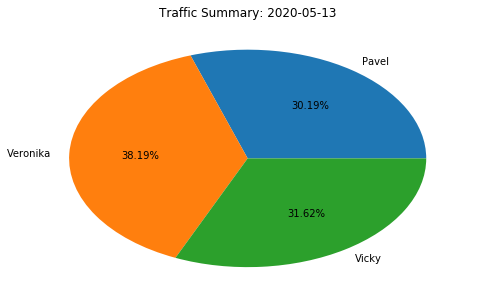

In [6]:
# --- Build a Pie Chart out of summary data:
plt.figure(figsize=(8,5))
plt.pie(x=traffic_summary["Traffic.MB"], labels=traffic_summary["User"], autopct="%.2f%%")
plt.title("Traffic Summary: {0}".format(logDate))
plt.show()

# TOP 10 web-sites statistics:

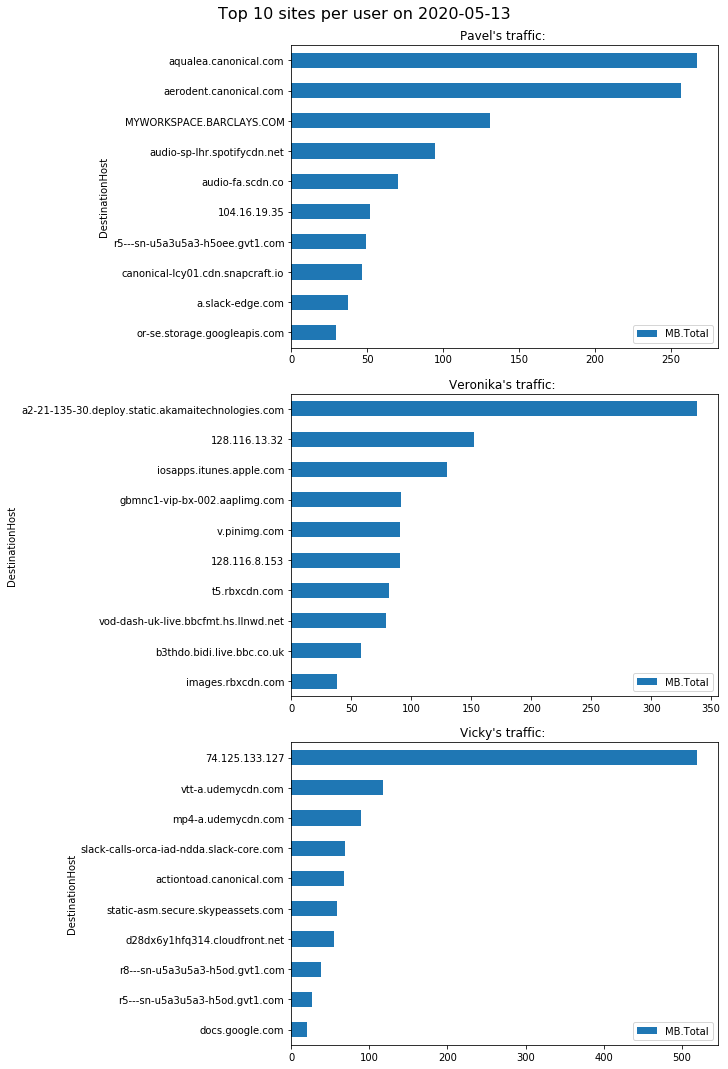

In [7]:
# --- if necessary apply additional transformation to "users" list.
# --- then:
# --- create subplots to place all graphs at the same figure:
fig, ax = plt.subplots(nrows=len(users), ncols=1, constrained_layout=True, sharex=False, sharey=False)
fig.set_size_inches(10, 15)
fig.suptitle("Top 10 sites per user on {0}\n".format(logDate), fontsize=16)

# --- iterate through uach reporting user and build their statistics:
size_unit = "MB"
for index, user in enumerate(users):    
    user_traffic_per_host  = pd.DataFrame({
        
        "DestinationHost": list(df.loc[df["User"] == user]\
            .groupby(["DestinationHost"]).groups),

        "{0}.Total".format(size_unit) : list(map(
            lambda size: BiteSize.transform(int(size), size_unit),
            list(df.loc[df["User"] == user]\
                .groupby(["DestinationHost"])\
                .agg(np.sum)["Bytes.Total"])
        ))
    })

    user_traffic_per_host\
        .sort_values(by="{0}.Total".format(size_unit), ascending=True)\
        .tail(10).set_index("DestinationHost")\
        .plot(kind="barh", ax=ax[index])
    
    ax[index].title.set_text("{0}'s traffic: ".format(user))
    # ax[index].get_yaxis().set_label_position("right")

plt.show()

## Query some particular user's details if necessary:

In [9]:
user_traffic = df.query(
        '`User` == "Veronika" \
        and `DATETIME` > "2020-05-13 17:00:00" \
        and `DATETIME` < "2020-05-13 18:10:00" \
        # and `DestinationHost`.str.contains("akamaitech") \
        ')[[
# --- columns ----------------------------------------------------------------------
        "User", "DATETIME", 
        "SourceHost", "SourceIp",
        "DestinationHost", "DestinationIp", 
        "DestinationPort", "Protocol",
        "Bytes.Total"]]

In [10]:
BiteSize.transform(int(user_traffic.groupby(["User"]).agg(np.sum)["Bytes.Total"].values[0]))

'446.19 MB'

In [ ]:
user_traffic

### Draw Top-10 bar:

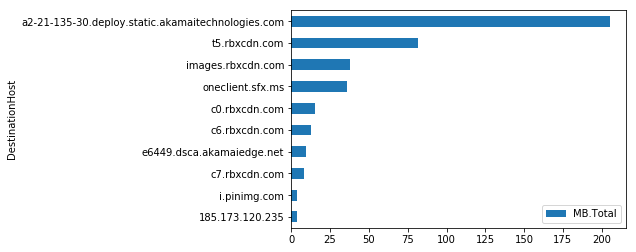

In [12]:
size_unit = "MB"
user_traffic_per_host  = pd.DataFrame({
    "DestinationHost": list(user_traffic\
        .groupby(["DestinationHost"]).groups),

    "{0}.Total".format(size_unit) : list(map(
        lambda size: BiteSize.transform(int(size), size_unit),
        list(user_traffic\
            .groupby(["DestinationHost"])\
            .agg(np.sum)["Bytes.Total"])
    ))
})

user_traffic_per_host\
    .sort_values(by="{0}.Total".format(size_unit), ascending=True)\
    .tail(10).set_index("DestinationHost")\
    .plot(kind="barh")
    
plt.show()